#### Imports and settings

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from random import randint
import re

from wordcloud import WordCloud, STOPWORDS
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, GlobalMaxPool1D, LSTM, Dropout, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Model, Sequential

%matplotlib inline
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


#### Customize IDE

In [2]:
# IDE theme
!jt -t chesterish -f roboto -fs 9 -nfs 11

In [3]:
# Font color on plots 
COLOR = 'A9B0C2'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

#### Load datasets and pretrained models

In [4]:
PATH = '../input/'
GLOVE_FILE = f'{PATH}glove.6B.50d.txt'
train = pd.read_csv(f'{PATH}train.csv')
test = pd.read_csv(f'{PATH}test.csv')

### EDA (Exploratory data analysis)

In [5]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [6]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [7]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
n_train = train.shape[0]
n_test = test.shape[0]
print("Samples in train dataset: ", n_train, "(", round(n_train * 100 / (n_train + n_test)), "% )")
print("Samples in test dataset: ", n_test, "(", round(n_test  *100 / (n_train + n_test)), "% )")

Samples in train dataset:  159571 ( 51 % )
Samples in test dataset:  153164 ( 49 % )


In [9]:
# Do not operate on original test dataset during EDA
train_extended = train.reset_index(drop=True)

In [10]:
comments_labels_train = train_extended.iloc[:,2:]
comments_labels_sums = comments_labels_train.sum(axis=1)
train_extended["clean"] = (comments_labels_sums == 0)
n_clean_samples = train_extended["clean"].sum()
n_toxic_samples = len(train_extended) - n_clean_samples
print("Clean: ", n_clean_samples, "(", round(n_clean_samples * 100 / len(train_extended)), "% )")
print("Toxic: ", n_toxic_samples, "(", round(n_toxic_samples * 100 / len(train_extended)), "% )")

Clean:  143346 ( 90.0 % )
Toxic:  16225 ( 10.0 % )


###### <font color="orange">The large majority of train dataset are comments labelled as clean</font>

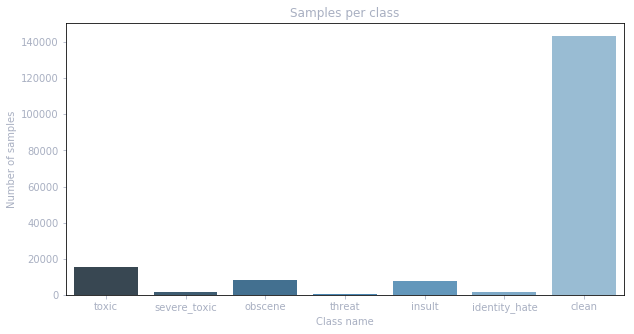

In [11]:
# extended by 'clean' column
summed_labels_extended_train = train_extended.iloc[:,2:].sum()

plt.figure(figsize=(10,5))
plt.title("Samples per class")
plt.ylabel("Number of samples")
plt.xlabel("Class name")
ax = sns.barplot(summed_labels_extended_train.index, summed_labels_extended_train.values, palette="Blues_d")
plt.show()

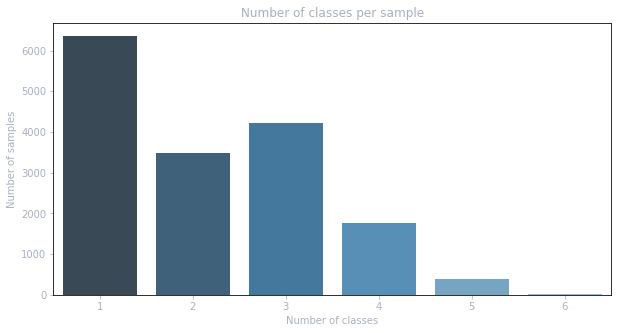

1    6360
3    4209
2    3480
4    1760
5     385
6      31
dtype: int64


In [12]:
# without '0 classes' (clean comments)
multiple_classes_occurance = comments_labels_sums.value_counts().iloc[1:]

plt.figure(figsize=(10,5))
plt.title("Number of classes per sample")
plt.ylabel("Number of samples")
plt.xlabel("Number of classes")
ax = sns.barplot(multiple_classes_occurance.index, multiple_classes_occurance.values, palette="Blues_d")
plt.show()
print(multiple_classes_occurance)

In [13]:
print("Single-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance.get(1) / n_toxic_samples * 100), '%')
print("Multiple-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance[1:].sum() / n_toxic_samples * 100), '%')

Single-classed toxic comments: 39.20 %
Multiple-classed toxic comments: 60.80 %


###### <font color="orange">Most of toxic comments has more than one toxic class</font>

#### Example samples

In [14]:
def get_random_sample(comments_group):
    min_samples_in_class = comments_labels_train.sum().min() - 1
    return comments_group.iloc[randint(0, min_samples_in_class),1]

In [15]:
toxic_samples = train_extended[train_extended.toxic == 1]
severe_toxic_samples = train_extended[train_extended.severe_toxic == 1]
obscene_samples = train_extended[train_extended.obscene == 1]
threat_samples = train_extended[train_extended.threat == 1]
insult_samples = train_extended[train_extended.insult == 1]
identity_hate_samples = train_extended[train_extended.identity_hate == 1]
clean_samples = train_extended[train_extended.clean == 1]

print("Toxic:\n\n", get_random_sample(toxic_samples))
print("\n --- \n\nSevere toxic:\n\n>", get_random_sample(severe_toxic_samples))
print("\n --- \n\nObscene:\n\n>", get_random_sample(obscene_samples))
print("\n --- \n\nThreat:\n\n>", get_random_sample(threat_samples))
print("\n --- \n\nInsult:\n\n>", get_random_sample(insult_samples))
print("\n --- \n\nIdentity hate:\n\n>", get_random_sample(identity_hate_samples))
print("\n --- \n\nClean:\n\n>", get_random_sample(clean_samples))

Toxic:

 WHAT'S WRONG WITH YOU?
GO KILL YOURSELF, YOU VILE CREATURE!!!!!!!!!!!

 --- 

Severe toxic:

> 72.94.188.92 

Yo what the fuck is your problem fucking around with my page! leave it the fuck alone!

 --- 

Obscene:

> I admit I'm stupid. I'm like all Russians, just a drunk gay with vodka in his pants.

 --- 

Threat:

> you edit 

YOU EDIT IS VANDAL! STOP OR DIE!

 --- 

Insult:

> Go masturbate yourself on someone else's page, you will get no satisfaction from me, slut.  Wikipedia is not the proper place for you to abuse your powers just because you're unsatisfied in life.  It ain't my fault you're ugly, sista.

 --- 

Identity hate:

> you people are pretty overzealous with this whole free thing.  get a fucking life, you fucking niggers !!!23 16!!!

 --- 

Clean:

> Gore response 

Can anybody find Gore's response to Bush's malaprop? Why didn't Gore, as the inventor of the darn thing, club him silly after that one?


#### Wordclouds

In [16]:
stopwords=set(STOPWORDS)

wordcloud_toxic = WordCloud(max_words=1000, stopwords=stopwords, colormap="Reds")
wordcloud_toxic.generate(" ".join(toxic_samples.comment_text.values))

wordcloud_clean = WordCloud(max_words=1000, stopwords=stopwords, colormap="Greens")
wordcloud_clean.generate(" ".join(clean_samples.comment_text.values))

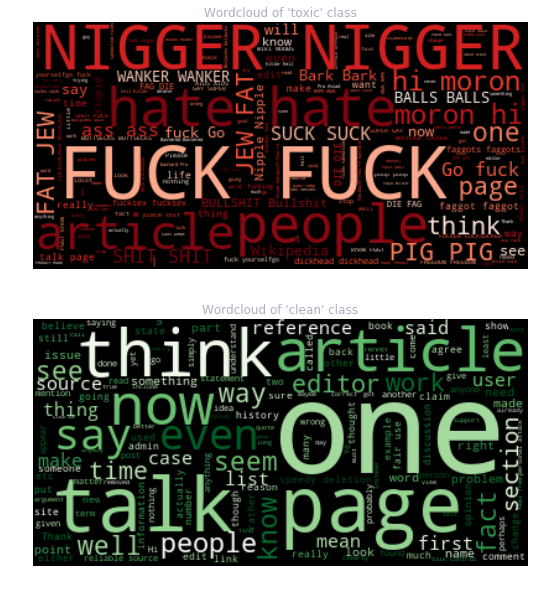

In [17]:
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.title("Wordcloud of \'toxic\' class")
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis("off")

plt.subplot(212)
plt.axis("off")
plt.title("Wordcloud of \'clean\' class")
plt.imshow(wordcloud_clean, interpolation='bilinear')

plt.show()

#### Spam significance 

In [76]:
train_extended['n_unique_words'] = train_extended["comment_text"].apply(lambda x: len(set(str(x).split())))
train_extended['n_words'] = train_extended["comment_text"].apply(lambda x: len(str(x).split()))
train_extended['unique_words_per'] = round(train_extended['n_unique_words'] * 100 / train_extended['n_words'])

In [93]:
spam_ratio = 10
spammers = train_extended[train_extended['unique_words_per'] < spam_ratio]
clean_spammers = spammers[spammers['clean'] == True]
toxic_spammers = spammers[spammers['clean'] == False]
n_clean_spammers = clean_spammers.shape[0]
n_toxic_spammers = toxic_spammers.shape[0]
n_spammers = spammers.shape[0]
print('Clean spammers: ', clean_spammers.shape[0], "(", round(n_clean_spammers * 100 / n_spammers), "% )")
print('Toxic spammers: ', toxic_spammers.shape[0], "(", round(n_toxic_spammers * 100 / n_spammers), "% )")
print('\nThere are', '{0:.2f}'.format(n_toxic_spammers / n_clean_spammers) ,'times more toxic spammers than clean ones!')

Clean spammers:  66 ( 19 % )
Toxic spammers:  290 ( 81 % )

There are 4.39 times more toxic spammers than clean ones!


### Tokenization of comments

In [79]:
# Get original training dataset
train.drop("clean", axis=1, inplace=True)

In [80]:
classes = train.columns.values[2:]

In [81]:
labeling_train = train[classes].values
comments_train = train["comment_text"]
comments_test = test["comment_text"]

#### <b><font color="green">TODO:</font></b> Experimentalize with 'max_n_words' values

In [82]:
max_n_words = 25000
tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(list(comments_train))

In [83]:
print('Found %d unique words.' % len(tokenizer.word_index))

Found 210337 unique words.


In [84]:
# Check first 20 unique words with the highest occurance from our dictonary
dict(list(tokenizer.word_index.items())[0:20])

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20}

In [85]:
tokenized_sequences_train = tokenizer.texts_to_sequences(comments_train)
tokenized_sequences_test = tokenizer.texts_to_sequences(comments_test)

In [86]:
# tokenized comment
tokenized_sequences_train[0]

[688,
 75,
 1,
 126,
 130,
 177,
 29,
 672,
 4511,
 12052,
 1116,
 86,
 331,
 51,
 2278,
 11448,
 50,
 6864,
 15,
 60,
 2756,
 148,
 7,
 2937,
 34,
 117,
 1221,
 15190,
 2825,
 4,
 45,
 59,
 244,
 1,
 365,
 31,
 1,
 38,
 27,
 143,
 73,
 3462,
 89,
 3085,
 4583,
 2273,
 985]

#### <b><font color="green">TODO:</font></b> Experimentalize with 'maxlen' values

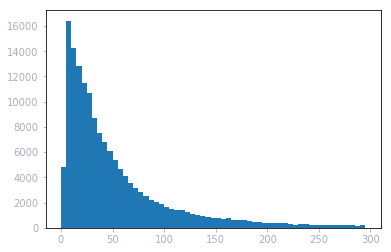

In [87]:
# Analysis of lengths of comments
n_words_comments = [len(comment) for comment in tokenized_sequences_train]
plt.hist(n_words_comments, bins=np.arange(0,300,5))
plt.show()

In [88]:
fixed_len = 180
fixed_sequences_train = pad_sequences(tokenized_sequences_train, maxlen=fixed_len)
fixed_sequences_test = pad_sequences(tokenized_sequences_test, maxlen=fixed_len)

In [89]:
print('Before padding: (', len(tokenized_sequences_train[6]) ,'elements )\n', tokenized_sequences_train[6])
print('After padding: (', len(fixed_sequences_train[6]) ,'elements )\n', fixed_sequences_train[6])

Before padding: ( 8 elements )
 [1873, 147, 6, 3476, 324, 15, 29, 141]
After padding: ( 180 elements )
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 1873  147    6 3476  32

### Building the model

In [90]:
input_layer = Input(shape=(fixed_len, ))

#### <b><font color="green">TODO:</font></b> Experimentalize with 'embedding_output_size' values

In [91]:
embedding_output_size = 64
embedding_layer = Embedding(input_dim=max_n_words, output_dim=embedding_output_size)(input_layer)

In [93]:
lstm_output_dim = 100
lstm_layer = LSTM(lstm_output_dim, return_sequences=True, recurrent_dropout=0.2)(embedding_layer)

#### <b><font color="green">TODO:</font></b> Try different variants of pooling (Average, Max etc.)

##### Try do add Conv1D(filters=32, kernel_size=3, padding='same', activation='relu') layer between embedding and pooling layers

In [94]:
max_pooling_layer = GlobalMaxPool1D()(lstm_layer)

In [95]:
dropout_rate = 0.2
dropout_layer = Dropout(rate=dropout_rate)(max_pooling_layer)

In [96]:
dense_output_dim = 50
dense_layer = Dense(50, activation='relu')(dropout_layer)

In [97]:
n_labels = len(classes)
sigmoid_layer = Dense(n_labels, activation='sigmoid')(dense_layer)
outputs = sigmoid_layer

In [98]:
model = Model(inputs=input_layer, outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [99]:
batch_size = 64
epochs = 2
X_train = fixed_sequences_train
y_train = labeling_train

In [12]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

NameError: name 'model' is not defined

In [ ]:
model.summary()

In [ ]:
X_test = fixed_sequences_test
y_test = model.predict([X_test], batch_size=1024, verbose=1)

In [ ]:
sample_submission = pd.read_csv(f'{PATH}sample_submission.csv')
sample_submission[classes] = y_test
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
def prepare_comment(comment):
    tokenized_comment = tokenizer.texts_to_sequences(comment)
    return pad_sequences(tokenized_comment, maxlen=fixed_len)

In [ ]:
single_comment = 'What a great man!'
single_prediction = model.predict([prepare_comment([single_comment])], batch_size=1024, verbose=1)
results = pd.DataFrame(single_prediction, columns=[classes])

class_with_highest_prob = results.idxmax(axis=1).get(0)[0]
highest_prob = results.max(axis=1).get(0)

happy_face = '\ (•◡•) /'
sad_face = '¯\_(ツ)_/¯'

if (highest_prob > .5):
    print('\nDeteced class: ', class_with_highest_prob, '\nScore: ', highest_prob * 100, ' %\n\n', sad_face)
else:
    print('\nNo toxicity detected!\n\n', happy_face)
print('\nAll results:\n', results)

#### TODOS:
- use pretrained models
- tuning of hyper-parameters
- early stopping during training model
- validate on test set

##### TF-IDF works by penalising these common words by assigning them lower weights while giving
##### importance to words like Messi in a particular document.